In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd
import pandas as pd
import seaborn as sns

from pygdsm import GlobalSkyModel2016

import src.powerlaw_regression as PR
import src.sky_models as SM
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

In [2]:
def splitvec(vec, nsplit):
    """
    Split a vector of length m into nsplit pieces, returning an array of shape
    nsplit x (m/nsplit).
    """
    if len(vec)%nsplit:
        raise ValueError("nsplit must divide vector length.")
    newvec = np.reshape(a=vec, newshape=(nsplit, int(len(vec)/nsplit)))
    return newvec

def gen_cl_matrix(nside=32, lmax=64, nuarr=np.linspace(50,100,51), sqrt=True):
    """
    Generate the power spectrum matrix (Nlmax, Nfreq) for the GSMA. If sqrt is 
    true, computes the square root of the matrix.
    """
    # Check the foreground generation is working.
    a, mp = SM.foreground_gsma_alm(nu=nuarr, map=True, lmax=lmax, nside=nside)
    a_sep = splitvec(a, len(nuarr))

    a_sep_compl = [RS.real2ComplexALM(almr) for almr in a_sep]
    cls = [hp.sphtfunc.alm2cl(almc) for almc in a_sep_compl]
    return np.sqrt(np.array(cls).T)

def preprocess_cl_matrix(cl_mat):
    """
    Multiply the power spectrum elements by l(l+1) for each row (ell) of the
    power spectrum matrix.
    """
    lmax = np.shape(cl_mat)[0]
    norm = np.array([l*(l+1) for l in range(lmax)])
    normed_cl_mat = cl_mat.T * norm
    return normed_cl_mat.T


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


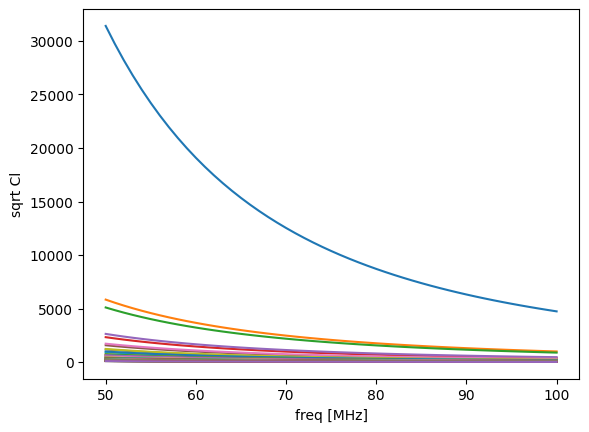

In [3]:
# Generate the power spectrum matrix, and normalise a version of it.
nuarr = np.linspace(50,100,51)
cl_mat = gen_cl_matrix(nuarr=nuarr)

plt.plot(nuarr, cl_mat.T)
plt.xlabel("freq [MHz]")
plt.ylabel("sqrt Cl")
plt.show()

In [7]:
_, _, fitpars_c0 = PR.power_law_residuals(nuarr/60, cl_mat[0])
fitpars_c0

array([ 9.85672685, -2.72832329])

[[ 8.20666873 -2.55694612]
 [ 8.07834082 -2.52727862]
 [ 7.28306456 -2.56968081]]


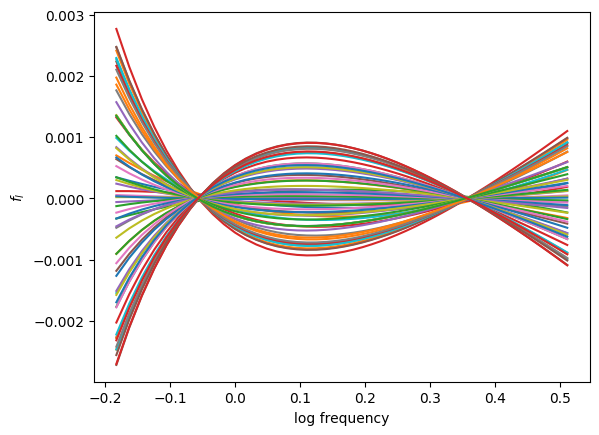

In [9]:
# Collapse the l>1 modes of the normalised and un-normalised Cl matrix.
lognu, resid, fitpars = PR.power_law_residuals(nuarr/60, cl_mat[1:])
print(fitpars[:3])
plt.plot(lognu, resid.T)
plt.xlabel("log frequency")
plt.ylabel('$f_l$')
plt.show()

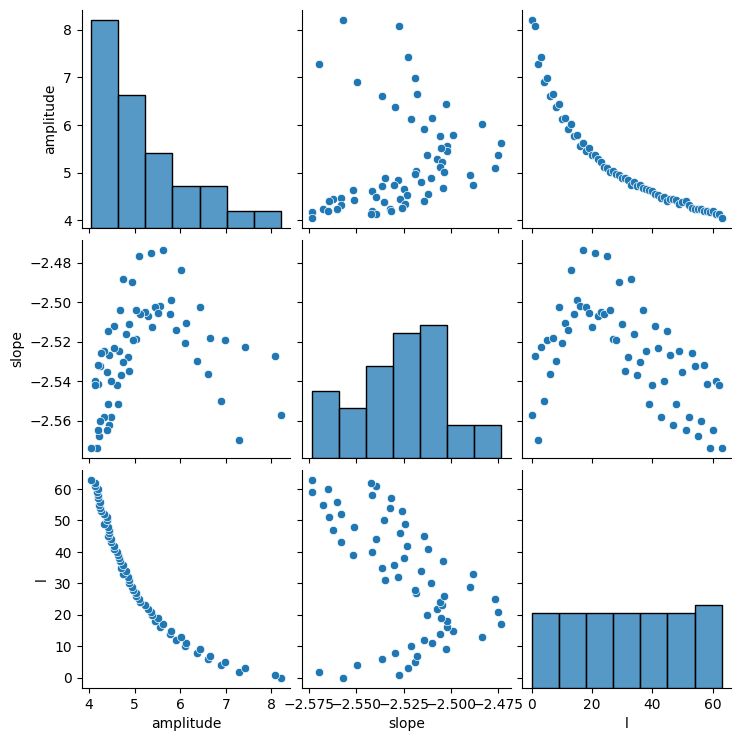

In [10]:
fitpars_frame = pd.DataFrame(fitpars, columns=["amplitude","slope"])
fitpars_frame['l'] = np.array(list(range(64)))
sns.pairplot(data=fitpars_frame)
plt.show()

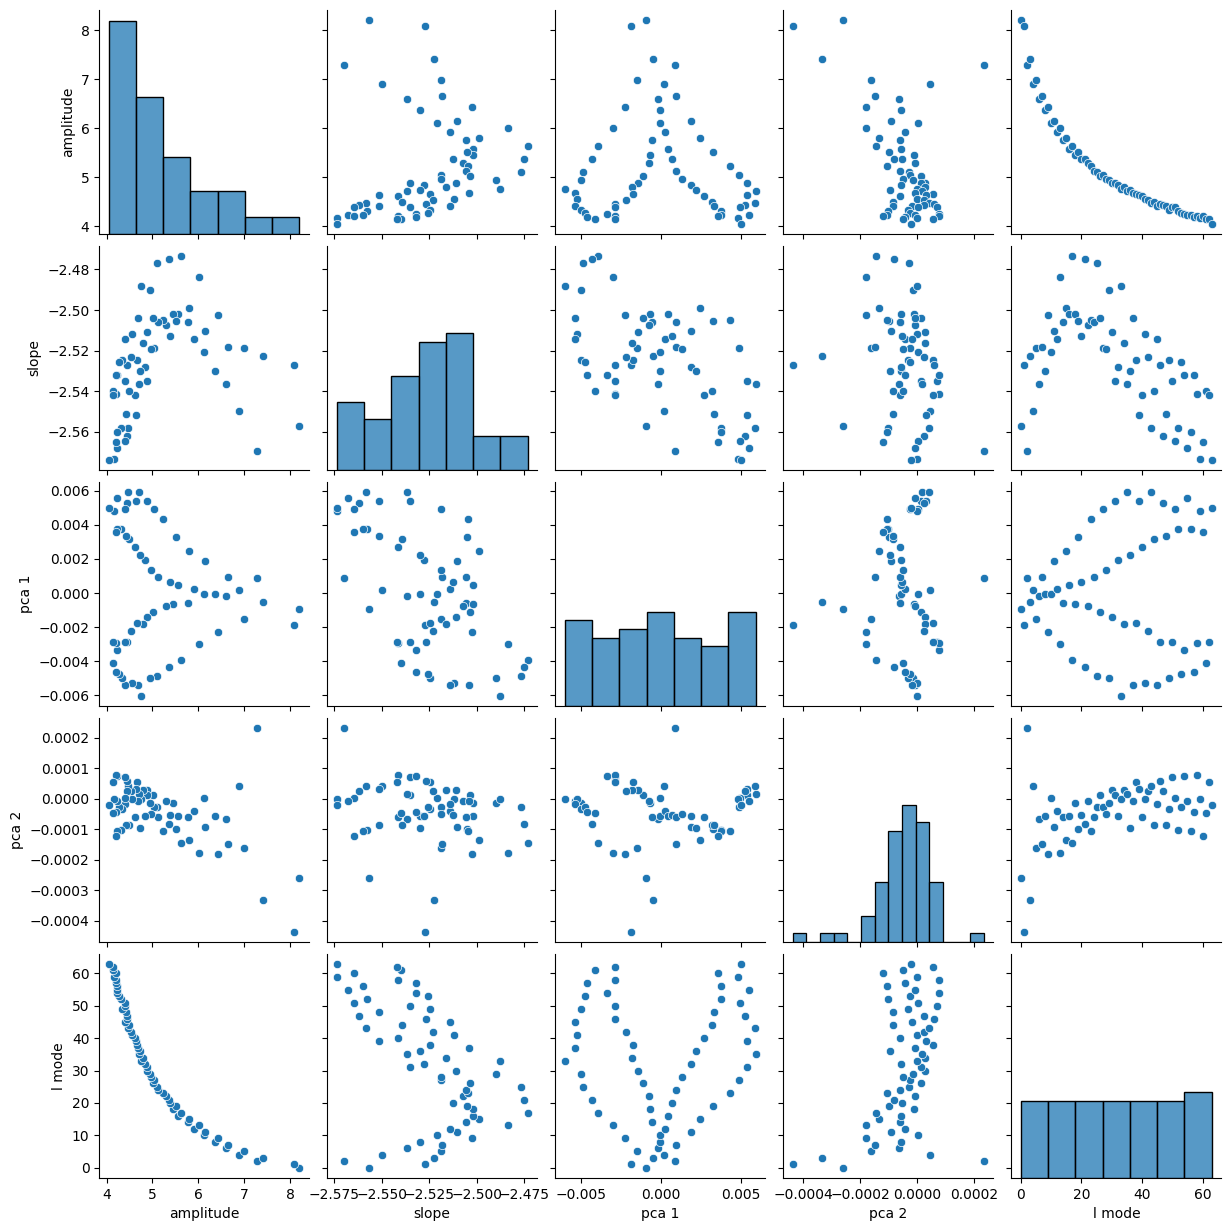

In [11]:
# SVD the residual matrices to find a basis.
Npca = 2
coord_mat, basis_mat = PR.pca(resid, N=Npca)

allpars_array = np.append(fitpars, coord_mat, axis=1)
allpars_frame = pd.DataFrame(allpars_array, columns=["amplitude", "slope", "pca 1", "pca 2"])
allpars_frame["l mode"] = list(range(64))
sns.pairplot(data=allpars_frame)
plt.show()

In [56]:
from importlib import reload
reload(PR)

<module 'src.powerlaw_regression' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/powerlaw_regression.py'>

In [57]:
bounds = ((np.exp(9), np.exp(10)),(-3, -2),(-1e-3, 1e-3),(-1e-3, 1e-3))
pos = np.array([np.random.uniform(*bound, size=12) for bound in bounds])
pos.T[0]

array([ 1.05309807e+04, -2.44056818e+00, -5.02991288e-05,  4.17749309e-04])

In [58]:
res=PR.fg_powerlawPCA_regression(nuarr, C0=cl_mat[0], pca_basis=basis_mat.T, 
                                 bounds=((np.exp(9), np.exp(10)),(-3, -2),(-1e-3, 1e-3),(-1e-3, 1e-3)))

(16, 4)


In [59]:
theta_mean = np.mean(res.get_chain(flat=True)[10000:], axis=0)
theta_mean

array([ 1.90863282e+04, -2.72832788e+00,  5.84194403e-04,  1.57572110e-04])

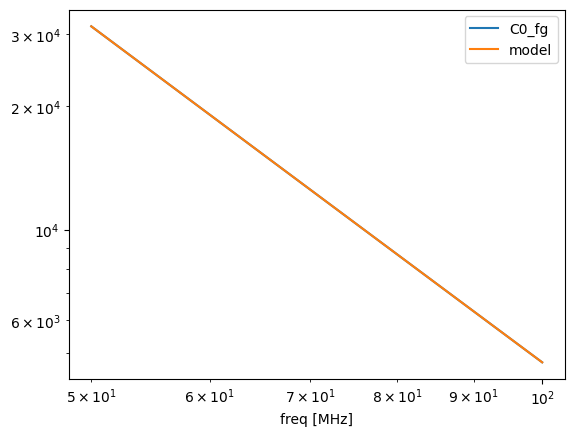

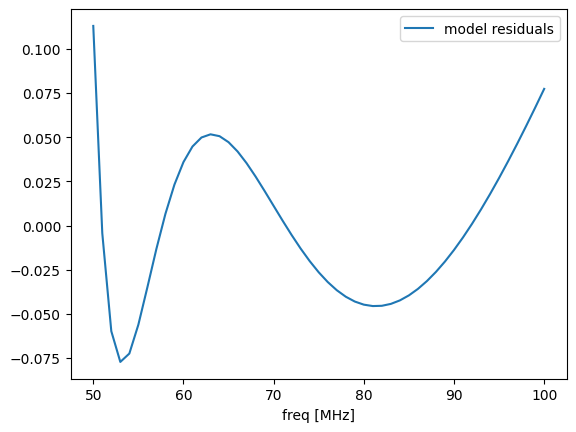

In [65]:
plt.loglog(nuarr, cl_mat[0], label='C0_fg')
plt.loglog(nuarr, PR.fg_powerlawPCA_forward_model(nuarr, theta_mean, pca_basis=basis_mat.T), label='model')
plt.xlabel("freq [MHz]")
plt.legend()
plt.show()
plt.plot(nuarr, cl_mat[0]-PR.fg_powerlawPCA_forward_model(nuarr, theta_mean, pca_basis=basis_mat.T), label="model residuals")
plt.xlabel("freq [MHz]")
plt.legend()

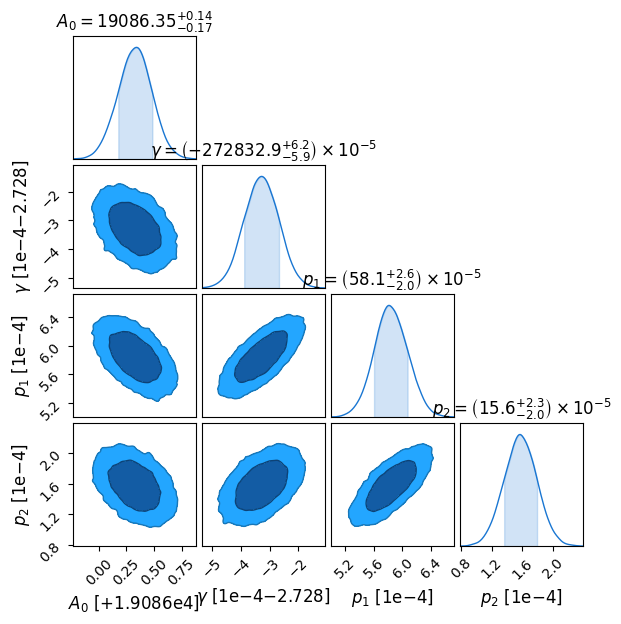

In [61]:
from chainconsumer import ChainConsumer
c=ChainConsumer()
c.add_chain(res.get_chain(flat=True)[10000:], parameters=["$A_0$", "$\gamma$", "$p_1$", "$p_2$"])
c.plotter.plot()
plt.show()

AttributeError: 'EnsembleSampler' object has no attribute 'x'

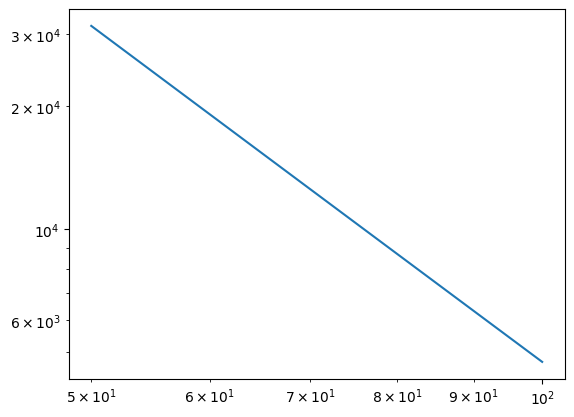

In [62]:
plt.loglog(nuarr, cl_mat[0])
plt.loglog(nuarr, PR.fg_powerlawPCA_forward_model(nuarr, res.x, pca_basis=basis_mat.T))
plt.show()
plt.plot(nuarr, np.abs(cl_mat[0]-PR.fg_powerlawPCA_forward_model(nuarr, res.x, pca_basis=basis_mat.T)))


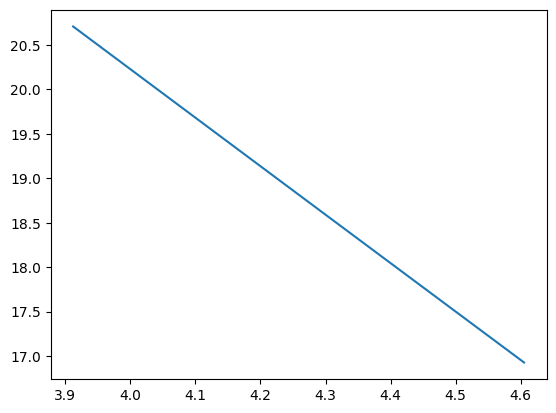

In [ ]:
plt.plot(np.log(nuarr), np.log(cl_mat[0]))

# Now do this with a 21-cm signal embedded in C0.

In [50]:
from importlib import reload
reload(PR)

<module 'src.powerlaw_regression' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/powerlaw_regression.py'>

In [51]:
# Embed the 21-cm signal in C0.
cm21_scale = 1e3             #  Adjust the scale for testing.
cls_fg21 = np.array(cl_mat)
cls_fg21[0] += cm21_scale*SM.cm21_globalT(nu=nuarr, A=0.2, nu0=80, dnu=5)  # Notice: we're introducing a positive, non-squared signal.

# Find the optimum PCA basis for C1->32.
Npca = 2
lognu, resid, fitpars = PR.power_law_residuals(nuarr/60, cls_fg21[1:])  # Collapse data.
coord_mat, basis_mat = PR.pca(resid, N=Npca)                            # PCA step.


sampler = PR.fg_powerlawPCA_cm21mon_regression(nuarr=nuarr, C0=cls_fg21[0], pca_basis=basis_mat.T, 
                                     bounds=((np.exp(9), np.exp(10)),(-5, -2),(-1e-3, 1e-3),(-1e-3, 1e-3), (cm21_scale*0.1, cm21_scale*0.3), (40, 100), (1, 10)))

(16, 7)


100%|██████████| 100000/100000 [02:29<00:00, 668.02it/s]


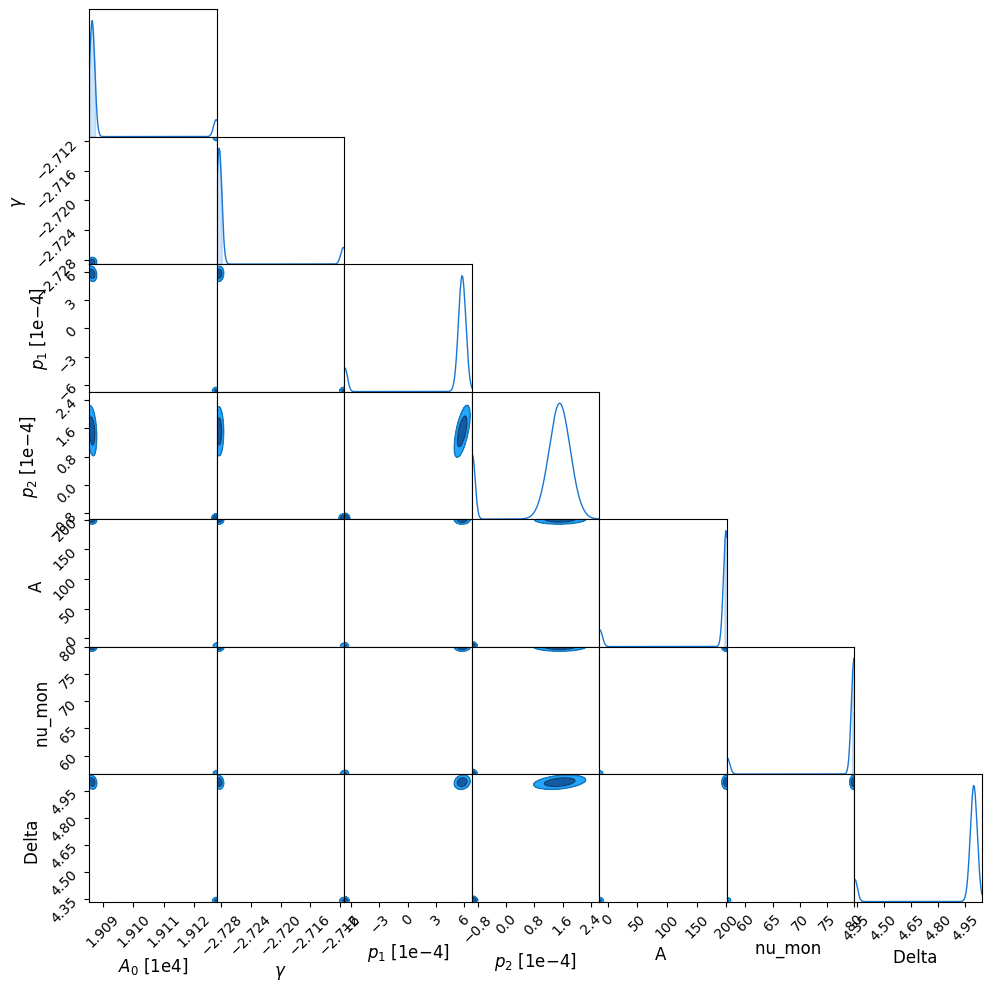

In [53]:
from chainconsumer import ChainConsumer
c=ChainConsumer()
c.add_chain(sampler.get_chain(flat=True)[1000000:], parameters=["$A_0$", "$\gamma$", "$p_1$", "$p_2$", "A", "nu_mon", "Delta"])
c.plotter.plot()
plt.show()

In [54]:
ch=sampler.get_chain(flat=True)[1000000:]

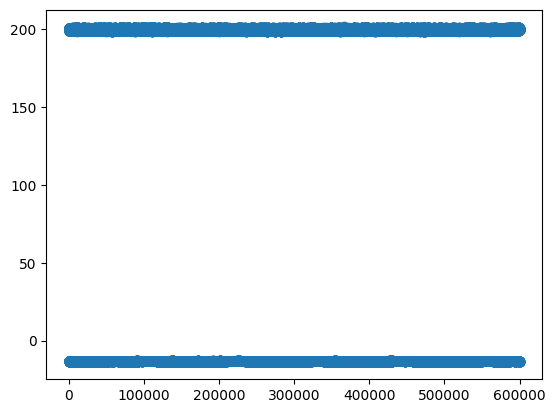

In [59]:
plt.scatter(list(range(len(ch[:,-3]))), ch[:,-3])